<a href="https://colab.research.google.com/github/s-jainr/deep-learning-sp23/blob/main/rahul_assessment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Example of data exploration, modeling, regulartion and prediction
Our exercise today involves loading a standard dataset using TensorFlow Keras API, exploring the data, building a simple neural network, and evaluating the effects of basic methods (activation functions, regularization, weight initialization, etc.). We then perform predictions on the test set and inspect the results. 

# 1. Data
The dataset we will use is the well-known CIFAR10 (Canadian Institute For Advanced Research). Explore the details on the Keras website first: https://keras.io/api/datasets/cifar10/

After you explored the basic features of the data, let's load it into the memory and explore the shapes:

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [3]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## 1.1. Exercise 
Display the first ten images of the training data. Hints:
* Axis 0 refers to the separate images, e.g. X_train[0]
* You can use the [Matplotlib Pyplot imshow function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) for displaying the image. Just don't forget to import Plotly first!
* A corresponding example, but you have to modify the code for your purpose: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly

In [4]:
decode_y = {0: "airplane",
            1: "automobile",
            2: "bird",
            3: "cat",
            4: "deer",
            5: "dog",
            6: "frog",
            7: "horse",
            8: "ship",
            9: "truck"}
decode_y

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

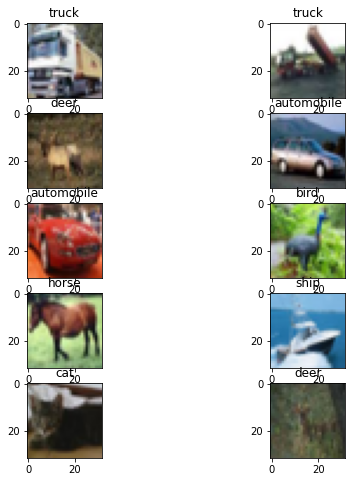

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 5
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(decode_y[Y_train[i][0]])
    plt.imshow(X_train[i])
plt.show()

Print the corresponding labels of the displayed images from the target variable (Y_train):

In [6]:
for i in range(rows*columns + 1):
    print(f'image {i}: labelled {Y_train[i][0]}, which is a {decode_y[Y_train[i][0]]}')

image 0: labelled 6, which is a frog
image 1: labelled 9, which is a truck
image 2: labelled 9, which is a truck
image 3: labelled 4, which is a deer
image 4: labelled 1, which is a automobile
image 5: labelled 1, which is a automobile
image 6: labelled 2, which is a bird
image 7: labelled 7, which is a horse
image 8: labelled 8, which is a ship
image 9: labelled 3, which is a cat
image 10: labelled 4, which is a deer


## 1.2. Exercise
We will train a Multi-Layer Perceptron (MLP), which requires a 2 dimensional input: 0th axis refers to the datapoints (i.e. images), the 1th dimens to the input. As images are 3 dimensional (width, height, color channels), you have to reshape the images into vectors. We also call this flattening. 

In order to do so, calculate the size of the equivalent 1D vector of the image:

In [7]:
flattened_dim = 3072

After you calculated it, we can reshape the images, and covert the integer arrays into float arrays -- which are needed for the neural networks as input. Hint:
* in the [reshape() function of Numpy](https://www.w3schools.com/python/numpy/numpy_array_reshape.asp) you can use -1 for one axis, to automatically calculate that value.

In [8]:
# reshape 3D tensors to 2D tensors
X_train = X_train.reshape((-1, flattened_dim))
X_test = X_test.reshape(((-1, flattened_dim)))

# it is in int8 format, the neural network requires float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

## 1.3. Exercise
As the next step, let's split the training data into training and validation data. 80% of the original training data should be the final training data, and 20% the validation.
You should use Numpy indexing to select the first 80% of X_train as final X_train, and the last 20% as X_valid. Hints: 
* https://datascienceparichay.com/article/numpy-array-first-n-rows/
* https://datascienceparichay.com/article/numpy-array-last-n-rows/

In [9]:
train_ratio  = 0.8
train_length = X_train.shape[0] # length of the training data
train_split  = int(train_length*train_ratio) # where to split the training and validation data

X_valid, Y_valid = X_train[:train_split], Y_train[:train_split]
X_train, Y_train = X_train[train_split:], Y_train[train_split:]

## 1.4. Exercise
As the last step of input data preparation, the data should be standardized. Calculate the mean and variance of the training data (elementvise -- so for each value of the flattened image you should get a mean and variance for the training data along 0th axis). Hint: 
* https://stackoverflow.com/questions/70626231/how-to-calculate-mean-variance-standard-deviation-per-index-of-array

In [10]:
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0)

Next, use the resulting values to standardize the training, validation and test data by substracting the mean and dividing the result with the standard deviation.

In [11]:
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test  = (X_test - mean) / std

## 1.5. Exercise
And as the last step, convert the dense representation of the classes (i.e. 0,1,2,3...9) to one-hot encoding (0 = [1 0 0 0 0 0 0 0 0 0], 1 = [0 1 0 0 0 0 0 0 0 0] ... 9 = [0 0 0 0 0 0 0 0 0 1]). To do this, first, calculate the number of unique elements in the target training data. Hints:
* use the [unique() function](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) of Numpy to list the unique elements
* you can count the number of elements in a list with the [len() function](https://www.w3schools.com/python/ref_func_len.asp)

In [12]:
nb_classes = len(np.unique(Y_train))
nb_classes

10

Doublecheck, if the same number of classes exists in the validation and test target data:

In [13]:
print("Validation data has the same number of classes, as the training data:", nb_classes == len(np.unique(Y_valid)))
print("Test data has the same number of classes, as the training data:", nb_classes == len(np.unique(Y_test)))

Validation data has the same number of classes, as the training data: True
Test data has the same number of classes, as the training data: True


And convert the dense representation into one-hot encoding. Hint:
* use the [to_categorical function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) with the calculated nb_classes


In [14]:
Y_train = to_categorical(Y_train, num_classes=nb_classes)
Y_valid = to_categorical(Y_valid, num_classes=nb_classes)
Y_test  = to_categorical(Y_test, num_classes=nb_classes)

## Final check of data preparation
Now, lets check the shapes and mean and standard deviation of the training, validation and test data.

In [15]:
print("Shapes of the training, validation and test input data:", X_train.shape, X_valid.shape, X_test.shape)
print("Shapes of the training, validation and test output data:", Y_train.shape, Y_valid.shape, Y_test.shape)
print("Mean values of the training, validation and test input data:", X_train.mean(), X_valid.mean(), X_test.mean())
print("Standard deviation of the training, validation and test input data:", X_train.std(), X_valid.std(), X_test.std())

Shapes of the training, validation and test input data: (10000, 3072) (40000, 3072) (10000, 3072)
Shapes of the training, validation and test output data: (10000, 10) (40000, 10) (10000, 10)
Mean values of the training, validation and test input data: -8.1857043e-10 -0.002343263 0.011031568
Standard deviation of the training, validation and test input data: 1.0000011 1.0036033 1.0013864


Don't worry, if the mean and standard deviation of the validation and test data are not exactly 0 and 1, but these might be very mear to it (e.g. 0.01 mean, 0.99 variance).

# 2. Training 

Let us begin with a simple example of creating a small neural network without regularization and training it with actual data. The purpose of this is to provide you with an example as to how to proceed with the next exercise. 

In [16]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# model definition
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(flattened_dim,)))
model.add(Dense(128, activation='tanh'))
model.add(Dense(nb_classes, activation='softmax'))

# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# training
network_history = model.fit(X_train, Y_train, 
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,                             
                            epochs=40, 
                            verbose=1)

Epoch 1/40
79/79 [==============================] - 4s 32ms/step - loss: 1.9551 - accuracy: 0.3221 - val_loss: 1.8387 - val_accuracy: 0.3542
Epoch 2/40
79/79 [==============================] - 2s 24ms/step - loss: 1.7287 - accuracy: 0.4021 - val_loss: 1.8231 - val_accuracy: 0.3561
Epoch 3/40
79/79 [==============================] - 2s 29ms/step - loss: 1.6334 - accuracy: 0.4359 - val_loss: 1.7950 - val_accuracy: 0.3725
Epoch 4/40
79/79 [==============================] - 2s 23ms/step - loss: 1.5639 - accuracy: 0.4652 - val_loss: 1.7800 - val_accuracy: 0.3810
Epoch 5/40
79/79 [==============================] - 2s 24ms/step - loss: 1.5017 - accuracy: 0.4895 - val_loss: 1.8044 - val_accuracy: 0.3815
Epoch 6/40
79/79 [==============================] - 2s 24ms/step - loss: 1.4388 - accuracy: 0.5137 - val_loss: 1.8148 - val_accuracy: 0.3776
Epoch 7/40
79/79 [==============================] - 2s 30ms/step - loss: 1.3891 - accuracy: 0.5330 - val_loss: 1.8151 - val_accuracy: 0.3836
Epoch 8/40
79

Let's plot the training and validation loss and accuracy curves:

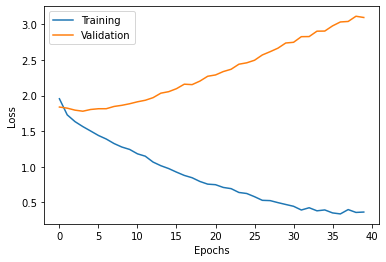

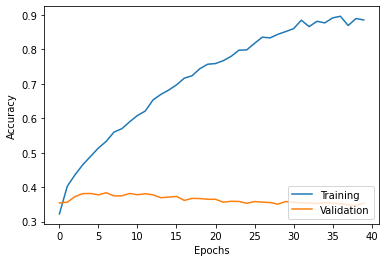

In [19]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

What do you think? Does it overfit? 

# Inspecting the model

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________


In [21]:
print('Input: ', model.input)

Input:  KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name='dense_input'), name='dense_input', description="created by layer 'dense_input'")


In [22]:
print('Layers:\n')
for layer in model.layers:
    print("Layer's name: ", layer.name, ', trainable: ', layer.trainable)
    print(layer.get_config(),'\n')

Layers:

Layer's name:  dense , trainable:  True
{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 3072), 'units': 128, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} 

Layer's name:  dense_1 , trainable:  True
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} 

Layer's name:  dense_2 , trainable:  True
{'name': 'dense_2', 'trainable': True, 'dtype': 'flo

In [23]:
print('Output: ', model.output)

Output:  KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")


## 2.1. Exercise
Introduce [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) and [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) with a rate between 0.1..0.5. Tips:

* Insert the dropout layer between the two Dense layers. 
* Set the patience of early stopping to 5.
* Set the number of epochs to a very high number.
* Don't forget to restore best weights after early stopping. 
* And also set early stopping to monitor validation accuracy (the default value is validation loss -- which is categorical crossentropy now).

Compile and train the model. Attempt to increase the validation accuracy as much as possible by making changes to the dropout rate. Inspect the effects of the modifications.

In [24]:
es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [25]:
# model definition with dropout
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(flattened_dim,)))
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(128, activation='tanh'))
model.add(Dense(nb_classes, activation='softmax'))

# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# training with early stopping
network_history = model.fit(X_train, Y_train, 
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,                             
                            epochs=1000000, 
                            verbose=1, 
                            callbacks=es)

Epoch 1/1000000
79/79 [==============================] - 6s 48ms/step - loss: 2.0961 - accuracy: 0.2651 - val_loss: 1.8880 - val_accuracy: 0.3353
Epoch 2/1000000
79/79 [==============================] - 3s 44ms/step - loss: 1.9226 - accuracy: 0.3129 - val_loss: 1.8344 - val_accuracy: 0.3596
Epoch 3/1000000
79/79 [==============================] - 4s 45ms/step - loss: 1.8905 - accuracy: 0.3269 - val_loss: 1.8158 - val_accuracy: 0.3643
Epoch 4/1000000
79/79 [==============================] - 3s 43ms/step - loss: 1.8487 - accuracy: 0.3451 - val_loss: 1.8040 - val_accuracy: 0.3715
Epoch 5/1000000
79/79 [==============================] - 3s 41ms/step - loss: 1.8343 - accuracy: 0.3527 - val_loss: 1.7887 - val_accuracy: 0.3711
Epoch 6/1000000
79/79 [==============================] - 3s 42ms/step - loss: 1.8159 - accuracy: 0.3588 - val_loss: 1.7735 - val_accuracy: 0.3790
Epoch 7/1000000
79/79 [==============================] - 3s 44ms/step - loss: 1.7929 - accuracy: 0.3666 - val_loss: 1.7824 -

## 2.2 Exercise
Change the [activation function of the dense layers (except the last one)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) to rectified linear unit (ReLU) and the [weight initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) to the theoretically best one. Use the original model's code.

Compile and train the model. Inspect the effects of the modifications.

In [28]:
# model definition with relu
model = Sequential()
model.add(Dense(128, activation='relu', kernel_initializer=HeNormal, input_shape=(flattened_dim,)))
model.add(Dense(128, activation='relu', kernel_initializer=HeNormal))
model.add(Dense(nb_classes, activation='softmax'))

# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# training
network_history = model.fit(X_train, Y_train, 
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,                             
                            epochs=40, 
                            verbose=1)

Epoch 1/40
79/79 [==============================] - 3s 24ms/step - loss: 2.1085 - accuracy: 0.3112 - val_loss: 1.9283 - val_accuracy: 0.3512
Epoch 2/40
79/79 [==============================] - 2s 26ms/step - loss: 1.6830 - accuracy: 0.4250 - val_loss: 1.8096 - val_accuracy: 0.3876
Epoch 3/40
79/79 [==============================] - 3s 34ms/step - loss: 1.4638 - accuracy: 0.4921 - val_loss: 1.7914 - val_accuracy: 0.3956
Epoch 4/40
79/79 [==============================] - 2s 24ms/step - loss: 1.3424 - accuracy: 0.5378 - val_loss: 1.7745 - val_accuracy: 0.4146
Epoch 5/40
79/79 [==============================] - 2s 25ms/step - loss: 1.2025 - accuracy: 0.5915 - val_loss: 1.8408 - val_accuracy: 0.4094
Epoch 6/40
79/79 [==============================] - 2s 23ms/step - loss: 1.1034 - accuracy: 0.6214 - val_loss: 1.8708 - val_accuracy: 0.4085
Epoch 7/40
79/79 [==============================] - 2s 24ms/step - loss: 1.0324 - accuracy: 0.6478 - val_loss: 1.9067 - val_accuracy: 0.4064
Epoch 8/40
79

# 2.3. Exercise
Based on the modifications above, and by any further modifications (e.g. more layers, less layers, more neurons/layer, etc.) to the model design, find a combination that is able to achieve **validation accuracy, that is higher than 53%**.


In [36]:
es2 = EarlyStopping(
	monitor='val_accuracy',
	min_delta=0,
	patience=5,
	verbose=0,
	mode='auto',
	baseline=None,
	restore_best_weights=True,
	start_from_epoch=0
)

In [90]:
from keras.layers import Conv2D, MaxPooling2D

# model definition
model = Sequential()
model.add(Dense(128, activation='relu', kernel_initializer=HeNormal, input_shape=(flattened_dim,)))
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(256, activation='relu', kernel_initializer=HeNormal))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu', kernel_initializer=HeNormal))
# model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))


# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 128)               393344    
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 256)               33024     
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_76 (Dense)            (None, 64)                16448     
                                                                 
 dense_77 (Dense)            (None, 10)                650       
                                                                 
Total params: 443,466
Trainable params: 443,466
Non-t

# 3. Evaluation on test data and inference
At this point, we will perform a basic evaluation and inference. With the model.evaluate function, the same metrics are calculated, that were used during training:

Epoch 1/10000
79/79 [==============================] - 5s 42ms/step - loss: 2.5095 - accuracy: 0.1733 - val_loss: 2.0906 - val_accuracy: 0.2538
Epoch 2/10000
79/79 [==============================] - 3s 42ms/step - loss: 2.1748 - accuracy: 0.2119 - val_loss: 1.9883 - val_accuracy: 0.2828
Epoch 3/10000
79/79 [==============================] - 5s 69ms/step - loss: 2.0533 - accuracy: 0.2529 - val_loss: 1.8855 - val_accuracy: 0.3031
Epoch 4/10000
79/79 [==============================] - 5s 68ms/step - loss: 1.9871 - accuracy: 0.2775 - val_loss: 1.8319 - val_accuracy: 0.3365
Epoch 5/10000
79/79 [==============================] - 6s 77ms/step - loss: 1.9154 - accuracy: 0.3045 - val_loss: 1.8063 - val_accuracy: 0.3504
Epoch 6/10000
79/79 [==============================] - 6s 71ms/step - loss: 1.8814 - accuracy: 0.3192 - val_loss: 1.7730 - val_accuracy: 0.3612
Epoch 7/10000
79/79 [==============================] - 5s 68ms/step - loss: 1.8423 - accuracy: 0.3321 - val_loss: 1.7504 - val_accuracy:

(0.0, 0.6)

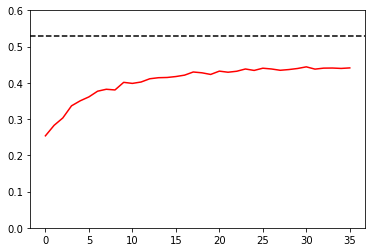

In [91]:
# training
network_history = model.fit(X_train, Y_train,
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,
                            epochs=10000,
                            verbose=1,
                            callbacks=es2)

f, ax = plt.subplots(1)
plt.axhline(y=0.53, color='black', linestyle='--')
plt.plot(network_history.epoch, network_history.history['val_accuracy'], color='red')
ax.set_ylim(ymin=0,
            ymax=max(
                max(network_history.history['val_accuracy']),
                0.6)
            )

In [94]:
print(model.evaluate(X_test, Y_test))

313/313 [==============================] - 1s 4ms/step - loss: 1.5721 - accuracy: 0.4495
[1.572083592414856, 0.4494999945163727]


we would like to see similar values, as in the validation set. If those are close to each other, then the generalization ability of the model is good (in case of an independent test-set).

## 3.1. Exercise
Predict the class of the first 10 elements in the test set, and compare the predicted values with the actual, target values in the test set. Hints:
* you can use [model.predict](https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/) for prediction
* from the output you can select the largest value with the [argmax() function of Numpy](https://stackoverflow.com/questions/62358642/convert-one-hot-encoding-back-to-number-label). As there are multiple values, you have to call it with axis=1 parameter.
* it is enought to compare the predictions and the targets by printing the values out and inspecting them.

In [ ]:
preds = <TODO>
preds_dense = <TODO>

Before comparision, you have to convert back the one-hot encoded target values the same way, as you converted the output of the neural network to class values with argmax() function.

In [ ]:
print("Target labels:", np.argmax(Y_test[:10],axis=1))
print("Predicted labels:", preds_dense)